# PD-GAN: Probabilistic Diverse GAN for Image Inpainting

Paper link: https://arxiv.org/pdf/2105.02201.pdf

Authors: Hongyu Liu, Ziyu Wan, Wei Huang, Yibing Song, Xintong Han1, Jing Liao
    
    
#### Group Members
Group No : 2
- Ali Ibrahim Ozkan / 2533750 / ozkan.ibrahim@metu.edu.tr
- Semih Soganci / 1679968 / e167996@metu.edu.tr



## Introduction

PD-GAN is a new generative adversarial network proposed to fill a masked image by utilizing the hard and soft probability diverse mask maps. First, a masked image was filled with a pretrained convolutional neural network. PD-GAN takes a previously filled image, its mask and a random noise as inputs and based on the random noise it tries to generate diversity in the padded regions. This is achieved by applying hard and soft mask maps in the SPD normalization blocks. Hard maps are generated for each mask in the SPD normalization layers and they are fixed for a mask. Soft maps are generated based on previous padding. No learning occurs on the hard probability maps while soft probability maps are trained at each iteration.

## Model Architecture

### Generator

Generator architecture contains a fully connected block, SPD normalization blocks and deconvolution blocks. A random noise is generated in the train loop and it is used for each batch. There is a fully connected block after the noise input. There are four SPD normalization blocks followed by four deconvolutional blocks. Each SPD normalization block operates at a different scale. Therefore, padded images and masks are downsampled to four levels (16x16, 32x32, 64x64, 128x128) by max pooling operation at the beginning of the generator loop. 

<img src="images/figure1.png">

Input and output sizes and channel widths of the fully connected block, normalization blocks and deconvolution blocks are given in Table 1.

<img src="images/table1.png">

#### SPD Normalization Block

Each SPD normalization block takes the output of the previous block, the downsampled image and the downsampled mask. There are two hard normalization blocks in series and there is one soft normalization block parallel to hard normalization branch. All subblocks in Normalization SPD Blocks are followed by a 3x3 convolution layer and a Relu activation layer. Outputs from soft and hard normalization branches are summed together and inputted to the next deconvolutional layer. Flow through normalization blocks can be seen in Figure 2. Stride, padding and output channel size are selected for the intermediate convolution blocks such that block dimensions are conserved through normalization.

<img src="images/figure2.png">

#### SPD Soft Normalization Block

Both in Hard SPD and Soft SPD normalization processes pretrained images are exposed to an intermediate convolutional layer. After that gamma and beta maps are calculated from separate convolutions. Soft normalization block utilizes soft mask probability maps (denoted as Ds and can be seen in Soft SPDNorm in Figure 2). They are constructed from the convolution of concatenated data of pretrained image and input coming from the prior blocks. This convolution is multiplied by the mask such that a probability distribution is generated only on the mask regions. Soft map is a filter on gamma and beta convolutions. At the end input is normalized, scaled with gamma block and shifted with beta block. Formulation can be seen in the following equation.


<img src="images/equation1.png">

#### SPD Hard Normalization Block

Hard normalization block utilizes hard mask probability maps (denoted as Dh and can be seen in Hard SPDNorm in Figure 2). They are constructed such that the mask regions are multiplied with coefficients according to the pixel distance to the gap edge. Hard filter is fixed for each mask and it is calculated by an iterative process. First, 3x3 kernels are generated in the mask regions. If the summation of a kernel is greater than zero, the code sets a nonzero coefficient to zero pixels. This coefficient is being set bigger for the pixels which are close to the boundary. It gets lower and lower for the middle pixels of the gap. By this way, shore lines are generated in the mask filter and boundary cells get more constrains from the image while more flexibility is achieved in the cells which are far away from the gap boundaries in terms of generation. Hard map is a filter on gamma and beta convolutions. At the end input is normalized, scaled with gamma block and shifted with beta block. Hard map calculation is time consuming. In order for cost saving, kernel size can be set larger, shore lines (padding levels of the mask) can be set to a lower number (idlt loop) and hard map calculation can be turned off for the large scale normalization blocks. Hard map and soft map coefficients can be comparatively seen in Figure 3 and also an example of the hard map and soft map distribution from our training loop be seen in Figure 3.

<img src="images/figure3.png">

As it can be seen from the sample in Figure 3, soft maps are constructed based on the pretrained image while hard maps are constructed based on the closeness to the gap boundary.


### Discriminator

Since a discriminator architecture is not given in the paper, we implemented a generic discriminator. Generated image and the ground truth image are provided to the discriminator class separately. Each image is convolved and reduced by size in the discriminator. Then, outputs are used to calculate the discriminator outside the class. Architectural details of discriminator are given in Table 2

<img src="images/table2.png">

### Loss Functions

Perceptual diversity loss which is proposed in the paper is used in implementation with reconstruction loss and feature matching loss.  Out1 = G(z1, P, M ) and Out2 = G(z2, P, M ) are two generated images conditioned on same coarse prediction P and image mask M but different latent vector z1 and z2. 
Fi is the i-th layer of a VGG-19 network pre-trained on ImageNet. Fi corresponds to the
activation maps from layers ReLU1 1, ReLU2 1, ReLU3 1, ReLU4 1, and ReLU5 1. The equation is shown below.





<img src="images/equation2.png">


### Import the Modules

In [1]:
import matplotlib.pyplot as plt # For plotting
from mpl_toolkits.axes_grid1 import ImageGrid
from library.models import * 
from library.discriminator import * 
from library.loss import *
import random
from metrics.fid import * # FID metric calculation function
from torchvision.utils import save_image
from library.dataset import *
import os
import re

random.seed(501)
np.random.seed(501)
torch.manual_seed(501)

# It automatically reloads your modules whenever
%load_ext autoreload
%autoreload 2

### Hyperparameters

In [2]:
batch_size = 1
learning_rate = 0.001
channel_size_for_first_spd_norm = 24 
image_size = 256 # input image size
k_for_hard_map = 2 # figure 3 in PD-GAN paper
noise_size = 30 # noise vector size
adam_optimizer_betas = (0.0, 0.99) # Adam Optimizer beta values
num_epochs = 5
seed = 0  # manual seed
device = 'cuda' 


### Device Setup

In [3]:
device = torch.device(device if (torch.cuda.is_available()) else 'cpu')
print("Device: " + str(device))
# seed for reproducibility
torch.manual_seed(seed)

Device: cuda


### Load Dataset

Helper functions which are in the below cell is used to visualize the samples during training/testing.


In [4]:
# Helper function for visualization
def show_dataset_images(images, image_name, row, column):
    fig = plt.figure(figsize=(12., 12.))


    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(row, column),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                      )
    # Arrange grid for visualization
    for i, (ax, im) in enumerate(zip(grid, images)):
        if i < column:
            ax.set_title(image_name[i])
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
    
def get_unnormalized_image(x,device="cpu",is_image_will_save = False):
    # Get Unnormalized image
    # x : normalized image
    # is_image_will_save : if the image will be saved, the transpose operation will be applied to the 

    # Mean and STD determines in library.dataset
    if is_image_will_save is True: x = x.transpose(1, 3)
    x = x * torch.Tensor(STD).to(device) + torch.Tensor(MEAN).to(device)
    if is_image_will_save is True: x = x.transpose(1, 3)
    return x

### Dataset
Originally, Places2 dataset is used in training. 

In our study, Places2 dataset is used in sky subcategory due to the time and computational limits. Images are in resolution of 256x256. Our dataset consists of three images; ground truth, mask and  generated image which was padded by a previously trained convolutional network. Each generated image has a unique mask. 

The explanations below contain the steps we used while preparing this dataset. You may use download_data.sh to download dataset.

#### Preperation Steps 
* Download Nvidia Mask Dataset (https://www.dropbox.com/s/01dfayns9s0kevy/test_mask.zip?dl=0)
* Classify according to mask ratio and transform to appropriate format (util/lib/mask_generation/generate_mask.py)
* Download Pretrained PC Based Model (https://github.com/naoto0804/pytorch-inpainting-with-partial-conv )
* Create Mask, Ground Truth images and PC-Generated images dataset (util/lib/pc_model_lib/test_pc_model.py)

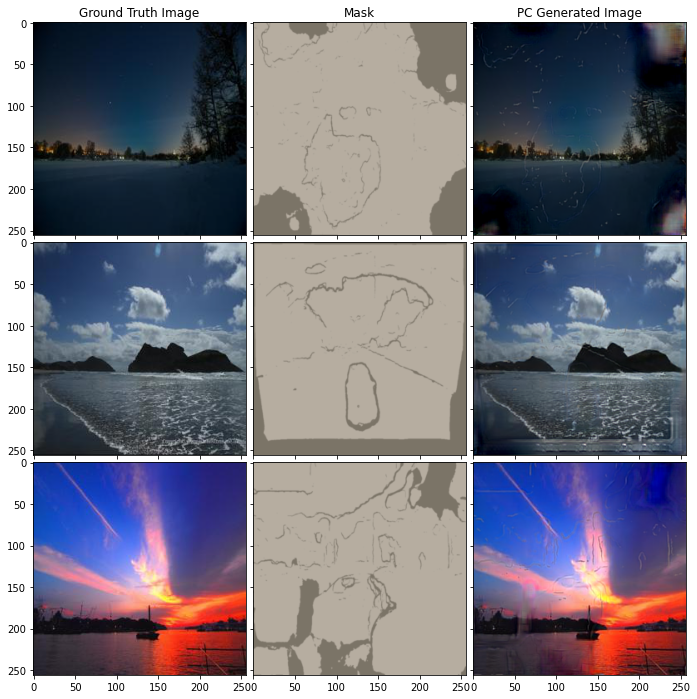

In [5]:
# Dataset class in library.dataset 

# Partial Convolution Generated images, Mask images and ground truth images are in the folder.
# The suffix of the names of Partial Convolution Generated images is '_generated'.
# The suffix of the names of Masks images is '_mask'.
# The suffix of the names of ground truth images is '_gt'.
# The name of the images -> ${IMAGE_NO}+${SUFFIX}.png

train_path = "dataset/data_20_30"

pc_gen_set = Dataset(train_path, '*_generated.png')
mask_set = Dataset(train_path, '*_mask.png')
gt_set = Dataset(train_path, '*_gt.png')


                
images = []
for i in range(3):
    images.append(get_unnormalized_image(gt_set[i].permute(1,2,0)))
    images.append(get_unnormalized_image(mask_set[i].permute(1,2,0)))
    images.append(get_unnormalized_image(pc_gen_set[i].permute(1,2,0)))

show_dataset_images(images,["Ground Truth Image","Mask","PC Generated Image"],3,3)



### Models Initialization

In [6]:
# PD-GAN class is in library.models
# discriminator class is in library.discriminator
# Parameters were determined in HyperParameters section

generator = PDGAN(channel_size_for_first_spd_norm, image_size, k_for_hard_map, noise_size)
discriminator = Discriminator()

# Set the Optimizer for generator 
generator = generator.to(device)
g_optim = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=adam_optimizer_betas)

# Set the Optimizer for discriminator 
discriminator = discriminator.to(device)
d_optim = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=adam_optimizer_betas)

### Training 

#### Dataloader

In [7]:
# Initalize data loader for training loop
pc_gen_loader = torch.utils.data.DataLoader(pc_gen_set, batch_size=batch_size, shuffle=False)
mask_loader = torch.utils.data.DataLoader(mask_set, batch_size=batch_size, shuffle=False)
gt_loader = torch.utils.data.DataLoader(gt_set, batch_size=batch_size, shuffle=False)
starting_epoch_no = 0

#### Load Pretrained Model for training (Optional)
The cell which is below is optional. 
If the pre-trained model will be used in training, you may use the below cell to load the model.

In [8]:
# Models Path
gen_path = "models/pd_gan_gen.pt"
dis_path = "models/pd_gan_dis.pt"

# Load checkpoint of generator
gen_checkpoint = torch.load(gen_path,map_location=device)
generator.load_state_dict(gen_checkpoint['model_state_dict'])
g_optim.load_state_dict(gen_checkpoint['optimizer_state_dict'])
starting_epoch_no = gen_checkpoint['epoch'] + 1
gen_loss = gen_checkpoint['loss']

# Load checkpoint of discriminator
dis_checkpoint = torch.load(dis_path,map_location=device)
discriminator.load_state_dict(dis_checkpoint['model_state_dict'])
d_optim.load_state_dict(dis_checkpoint['optimizer_state_dict'])
starting_epoch_no = dis_checkpoint['epoch'] + 1
dis_loss = dis_checkpoint['loss']

#### Training Loop

Note: The First 5 epoch outputs are visualized.

Epoch No: 0


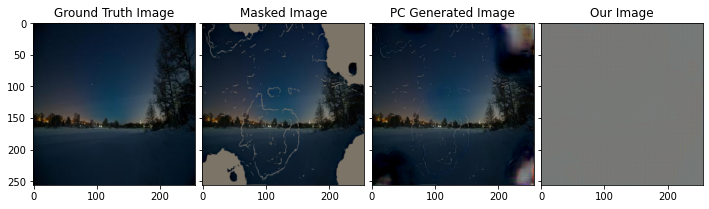

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch No: 1


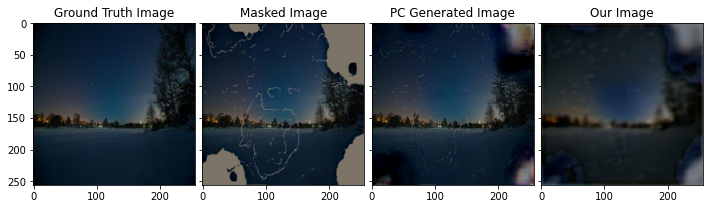

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch No: 2


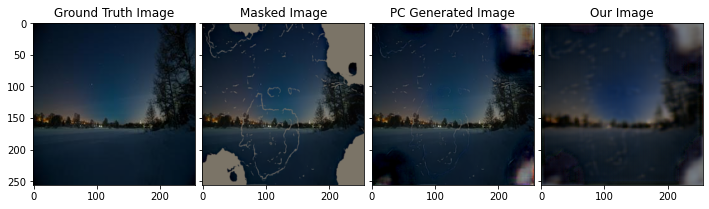

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch No: 3


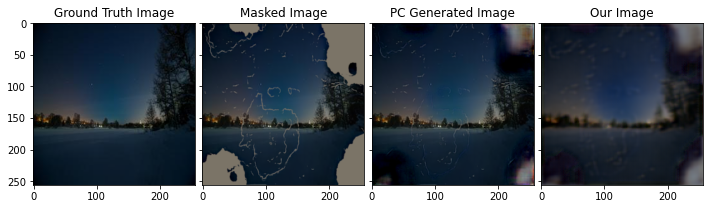

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch No: 4


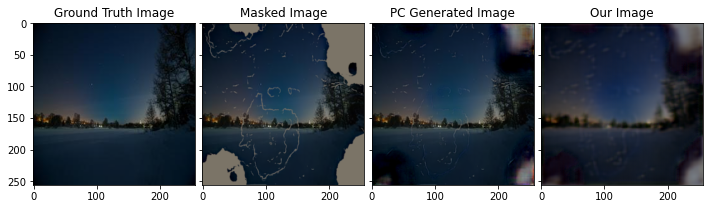

In [8]:
img, out = None, [None, None]
for epoch in range(starting_epoch_no, starting_epoch_no+num_epochs):
    is_image_shown = False
    for i, (pc_image_batch, mask_batch, gt_batch) in enumerate(zip(pc_gen_loader, mask_loader, gt_loader)):
        # Set generator and discriminator to train mode
        generator.train()
        discriminator.train()
        
        # Load Batches data to device
        pc_image_batch = pc_image_batch.to(device)
        mask_batch = mask_batch.to(device)
        gt_batch = gt_batch.to(device)
        
        
        discriminator_loss, reconstruction_loss = 0, 0
        for i in range(2):
            # Generate noise randomly
            noise_ = torch.randn(batch_size, noise_size, noise_size)
            noise_ = noise_.to(device)
            
            # Run the generator
            img, mask, out[i] = generator(pc_image_batch, mask_batch, noise_)

            # Run the discriminator
            pred_fake, pred_fake_layers = discriminator(out[i])
            pred_real, pred_real_layers = discriminator(gt_batch)
            
            # Calculate discriminator loss
            discriminator_loss = 0.5*GANLoss()(pred_fake, False, device) + 0.5*GANLoss()(pred_real, True, device)
            
            # Calculate feature matching loss for generator training
            GAN_feature_matching_loss = 0
            for layer_no in range(len(pred_real_layers)):
                GAN_feature_matching_loss += calculate_feature_matching_loss(pred_real_layers[layer_no], pred_fake_layers[layer_no])
            
            # Calculate reconstruction loss of input
            reconstruction_loss += calculate_reconstruction_loss(out[i], gt_batch)
        
        # Calculate perceptual loss of generator (eq 6 in PD-GAN paper)
        perceptual_loss = calculate_perceptual_loss(out[0], out[1], device)
        
        # Calculate total loss
        generator_loss = reconstruction_loss + GAN_feature_matching_loss + perceptual_loss      
        
        # Bacprop
        g_optim.zero_grad()
        generator_loss.backward(retain_graph=True)
        g_optim.step()
        
        # Backprop
        d_optim.zero_grad()
        discriminator_loss.backward(retain_graph=True)
        d_optim.step()    

        if epoch < starting_epoch_no + 5:
            if is_image_shown is False:
                print("Epoch No: " + str(epoch))
                shown_images = []
                masked_image = mask * img
                shown_images.append(get_unnormalized_image(gt_batch[0].detach().cpu().permute(1,2,0), 'cpu'))
                shown_images.append(get_unnormalized_image(masked_image[0].cpu().detach().permute(1,2,0), 'cpu'))
                shown_images.append(get_unnormalized_image(img[0].detach().cpu().permute(1,2,0), 'cpu'))
                shown_images.append(get_unnormalized_image(out[0][0].detach().cpu().permute(1,2,0), 'cpu'))
                show_dataset_images(shown_images,["Ground Truth Image","Masked Image","PC Generated Image", "Our Image"],1,4)
                plt.show()
                is_image_shown = True
                
    torch.save({
    'epoch': epoch,
    'model_state_dict': generator.state_dict(),
    'optimizer_state_dict': g_optim.state_dict(),
    'loss': generator_loss,
    }, "models/generator_" + str(epoch) + ".pt")

    torch.save({
    'epoch': epoch,
    'model_state_dict': discriminator.state_dict(),
    'optimizer_state_dict': d_optim.state_dict(),
    'loss': discriminator_loss,
    }, "models/discriminator_" + str(epoch) + ".pt")
    


### Load Pretrained Model

In [11]:
# Load Pretrained PDGAN model to test

# Models Path
gen_path = "models/pd_gan_gen.pt"
generator = PDGAN(channel_size_for_first_spd_norm, image_size, k_for_hard_map, noise_size)
generator = generator.to(device)

# Load checkpoint of generator
gen_checkpoint = torch.load(gen_path,map_location=device)
generator.load_state_dict(gen_checkpoint['model_state_dict'])


<All keys matched successfully>

### Targeted Quantitative Results

Our goal is reproducing the FID results published in paper.

<img src="images/fid.png">





FID score of PC Model and Our Model is shown below. FID calculation script is metrics/fid.py. 
Pretrained Inception V3 model is used in calculation.

#### Prepare PD-GAN Output Image (Optional) 
The cell which is below is optional. 
If the downloaded dataset is used to FID calculation, you may find the PD-GAN output image in this folder.

In [12]:
dataset_paths = ["test_data/data_10_20","test_data/data_20_30","test_data/data_30_40","test_data/data_40_50"]

# Generate PDGAN image with different mask ratio
for dataset in dataset_paths:
    print("Generating PD-GAN images in " + dataset)
    pc_gen_goal_set = Dataset(dataset, '*_generated.png')
    mask_goal_set = Dataset(dataset, '*_mask.png')
    gt_goal_set = Dataset(dataset, '*_gt.png')

    # Load Dataset to DataLoader
    goal_pc_gen_loader = torch.utils.data.DataLoader(pc_gen_goal_set, batch_size=1, shuffle=False)
    goal_mask_loader = torch.utils.data.DataLoader(mask_goal_set, batch_size=1, shuffle=False)
    goal_gt_loader = torch.utils.data.DataLoader(gt_goal_set, batch_size=1, shuffle=False)
    shown_images = []

    for i, (pc_image_batch, mask_batch, gt_batch) in enumerate(zip(goal_pc_gen_loader, goal_mask_loader, goal_gt_loader)):
        # Get image name
        img_name = re.split("/", str(gt_goal_set.files[i]))[-1]
        img_name = re.split("\.", img_name)[0]
        img_name = re.split("_", img_name)[0]

        # Load Batches data to device
        pc_image_batch = pc_image_batch.to(device)
        mask_batch = mask_batch.to(device)
        gt_batch = gt_batch.to(device)

        # Generate noise randomly
        noise_ = torch.randn(1, noise_size, noise_size)
        noise_ = noise_.to(device)

        # Test pretained model
        with torch.no_grad():
            img, mask, out = generator(pc_image_batch, mask_batch, noise_)
          
        # Save Image
        norm_img = get_unnormalized_image(out.cpu(),'cpu',True)
        saved_img_path = os.path.join(dataset , (img_name + '_pdgan.png'))
        save_image(norm_img, saved_img_path)



Generating PD-GAN images in test_data/data_10_20
Generating PD-GAN images in test_data/data_20_30
Generating PD-GAN images in test_data/data_30_40
Generating PD-GAN images in test_data/data_40_50


#### Calculate FID

In [13]:
dataset_paths = ["test_data/data_10_20","test_data/data_20_30","test_data/data_30_40","test_data/data_40_50"]

# Determine image name suffix
ground_truth_img_suffix = "gt"
pdgan_img_suffix = "pdgan"
pc_conv_img_suffix = "generated"


# Calculate FID of PC Model
pdgan_model_fids = []
for path in dataset_paths:
    # Get ratio of mask
    ratio = re.split("/", str(path))[-1]
    ratio = re.split("_", ratio)
    print("Our Image with " + str(ratio[1]) + "-" + str(ratio[2]) + "% Mask Ratio" )
    
    #Calculate Fid
    pdgan_model_fid_value = calculate_fid_given_paths(path, 10, ground_truth_img_suffix, pdgan_img_suffix, device)
    pdgan_model_fids.append(pdgan_model_fid_value)

    
# Calculate FID of PC Model
pc_model_fids = []
for path in dataset_paths:
    # Get ratio of mask
    ratio = re.split("/", str(path))[-1]
    ratio = re.split("_", ratio)
    print("Partial Convolution Model Image with " + str(ratio[1]) + "-" + str(ratio[2]) + "% Mask Ratio" )
    
    #Calculate Fid
    pc_model_fid_value = calculate_fid_given_paths(path, 10, ground_truth_img_suffix, pc_conv_img_suffix, device)
    pc_model_fids.append(pc_model_fid_value)

Our Image with 10-20% Mask Ratio
Calculating FID...


0it [00:00, ?it/s]
100%|██████████| 30/30 [00:19<00:00,  1.56it/s]
/home/ibrahim/.local/lib/python3.6/site-packages/scipy/linalg/_matfuncs_sqrtm.py:189: RuntimeWarning: invalid value encountered in double_scalars
  arg2 = norm(X.dot(X) - A, 'fro')**2 / norm(A, 'fro')


Our Image with 20-30% Mask Ratio
Calculating FID...


0it [00:00, ?it/s]
100%|██████████| 30/30 [00:20<00:00,  1.44it/s]


Our Image with 30-40% Mask Ratio
Calculating FID...


0it [00:00, ?it/s]
100%|██████████| 30/30 [00:20<00:00,  1.44it/s]


Our Image with 40-50% Mask Ratio
Calculating FID...


0it [00:00, ?it/s]
100%|██████████| 30/30 [00:20<00:00,  1.43it/s]


Partial Convolution Model Image with 10-20% Mask Ratio
Calculating FID...


0it [00:00, ?it/s]
100%|██████████| 30/30 [00:20<00:00,  1.43it/s]


Partial Convolution Model Image with 20-30% Mask Ratio
Calculating FID...


0it [00:00, ?it/s]
100%|██████████| 30/30 [00:20<00:00,  1.43it/s]


Partial Convolution Model Image with 30-40% Mask Ratio
Calculating FID...


0it [00:00, ?it/s]
100%|██████████| 30/30 [00:21<00:00,  1.43it/s]


Partial Convolution Model Image with 40-50% Mask Ratio
Calculating FID...


0it [00:00, ?it/s]
100%|██████████| 30/30 [00:21<00:00,  1.42it/s]


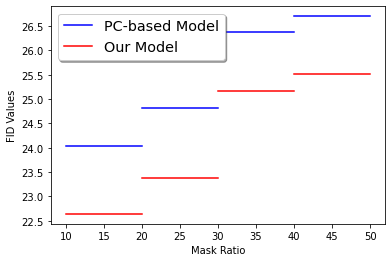

Mask Ratio 10-20 -> PC - FID:24.030234070877533, Ours - FID:22.64131136726914
Mask Ratio 20-30 -> PC - FID:24.820426400663578, Ours - FID:23.385476836100082
Mask Ratio 30-40 -> PC - FID:26.378583445979576, Ours - FID:25.16147183516292
Mask Ratio 40-50 -> PC - FID:26.700003085231568, Ours - FID:25.5151511966575



In [14]:
# The FID results is shown in the figure below 
# X axis is mask ratio, while y axis is FID result

plt.plot([10,20],[pc_model_fids[0],pc_model_fids[0]],color='blue',label='PC-based Model')
plt.plot([20,30],[pc_model_fids[1],pc_model_fids[1]],color='blue')
plt.plot([30,40],[pc_model_fids[2],pc_model_fids[2]],color='blue')
plt.plot([40,50],[pc_model_fids[3],pc_model_fids[3]],color='blue')
plt.plot([10,20],[pdgan_model_fids[0],pdgan_model_fids[0]],color='red',label='Our Model')
plt.plot([20,30],[pdgan_model_fids[1],pdgan_model_fids[1]],color='red',)
plt.plot([30,40],[pdgan_model_fids[2],pdgan_model_fids[2]],color='red')
plt.plot([40,50],[pdgan_model_fids[3],pdgan_model_fids[3]],color='red')

plt.xlabel('Mask Ratio')
plt.ylabel('FID Values')
plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.show()

print(
"Mask Ratio 10-20 -> PC - FID:"+ str(pc_model_fids[0]) + ", Ours - FID:"+ str(pdgan_model_fids[0]) + "\n"
"Mask Ratio 20-30 -> PC - FID:"+ str(pc_model_fids[1]) + ", Ours - FID:"+ str(pdgan_model_fids[1]) + "\n"
"Mask Ratio 30-40 -> PC - FID:"+ str(pc_model_fids[2]) + ", Ours - FID:"+ str(pdgan_model_fids[2]) + "\n"
"Mask Ratio 40-50 -> PC - FID:"+ str(pc_model_fids[3]) + ", Ours - FID:"+ str(pdgan_model_fids[3]) + "\n"
)

#### Quantitative Result Discussion
As can be seen from these results, our model gave consistent results with the pre-trained PC model. 

As the Mask Ratio increased, our FID values increased and better results were obtained in all mask ratios than in the pre-trained model. However, our model has better results than our targets. Moreover, the pre-trained PC model results also better than the results that specified in the paper. It is thought that there is a difference between our fid calculation methods and the methods in the paper since the fid results of the pre-trained PC model are also different as indicated in the paper. 

The reason for the difference between our results and target results might be the differences in the images used and the placement of the masks. To increase image diversity, we created a test set and used it for FID calculation. Thus, we achieved slightly better FID results.

The model used in the FID calculation may cause this difference, the model wasn't also explained in the paper. We tried 2 different Inception Models in FID calculation, however, the results didn't changed much.

### Targeted Qualitative Results

Our goal is reproducing the images which are below.

<img src="images/figure4.png">

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


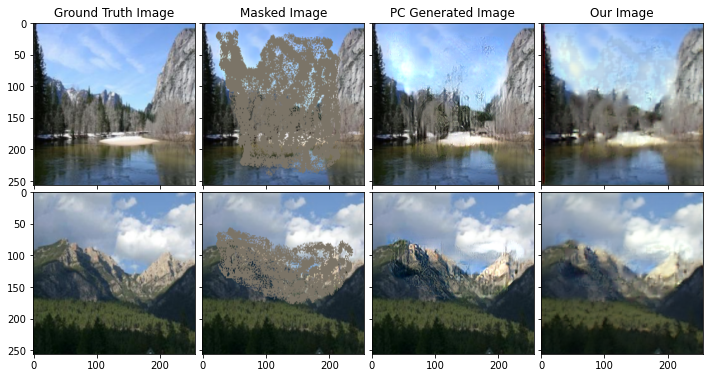

In [15]:
# Load Target dataset
goal_folder_path = "goal_dataset/goal_generated"
pc_gen_goal_set = Dataset(goal_folder_path, '*_generated.png')
mask_goal_set = Dataset(goal_folder_path, '*_mask.png')
gt_goal_set = Dataset(goal_folder_path, '*_gt.png')


# Load Target Dataset to DataLoader
goal_pc_gen_loader = torch.utils.data.DataLoader(pc_gen_goal_set, batch_size=1, shuffle=False)
goal_mask_loader = torch.utils.data.DataLoader(mask_goal_set, batch_size=1, shuffle=False)
goal_gt_loader = torch.utils.data.DataLoader(gt_goal_set, batch_size=1, shuffle=False)
shown_images = []


for pc_image_batch, mask_batch, gt_batch in zip(goal_pc_gen_loader, goal_mask_loader, goal_gt_loader):
    # Load Batches data to device
    pc_image_batch = pc_image_batch.to(device)
    mask_batch = mask_batch.to(device)
    gt_batch = gt_batch.to(device)
    
    # Generate noise randomly
    noise_ = torch.randn(1, noise_size, noise_size)
    noise_ = noise_.to(device)
    
    # Test pretained model
    with torch.no_grad():
        img, mask, out = generator(pc_image_batch, mask_batch, noise_)
    
    # Visualization of Target Data
    masked_image = mask * img
    shown_images.append(get_unnormalized_image(gt_batch[0].detach().cpu().permute(1,2,0), 'cpu'))
    shown_images.append(get_unnormalized_image(masked_image[0].detach().cpu().permute(1,2,0), 'cpu'))
    shown_images.append(get_unnormalized_image(img[0].detach().cpu().permute(1,2,0), 'cpu'))
    shown_images.append(get_unnormalized_image(out[0].detach().cpu().permute(1,2,0), 'cpu'))
    
show_dataset_images(shown_images,["Ground Truth Image","Masked Image","PC Generated Image", "Our Image"],2,4)
plt.show()

#### Qualitative Result Discussion
As can be seen in the qualitative results, our model produced pictures that were close to our targets. 
As the mask ratio increases, the quality of the produced image decreases slightly. This may be because we do not do training too much at high mask rates.

### Implementation challenges

We encounter several issues while implementing the PDGAN paper. The challenges are explained below.

#### 1) Dataset Preperation
* The paper states that the partial convolution-based encoder model outputs are used for the input of the PD-GAN  Model. Unfortunately, it did not contain much information about the pretrained PC-based model. At this stage, we lost time on how to use the PC-based model. 
* For the masks, the paper states irregular masks are used. Since there is no information about the regions the masks used, we preferred to use NVIDIA masks. 

#### 2) Implementation
* The paper explains the main structure, however; it does not provide an extra supplementary for the model structure. Therefore, we had to determine the dimensions other than the image dimension during the design phase. The paper does not contain critical detail of the architecture. We did not find the detail of the convolutional layers.
* The paper does not have any implementation detail of the discriminator. Therefore, we decided the architecture of the discriminator.    

#### 3) Evaluation
* The paper uses the FID results for comparison with other models. However, the paper doesn't have any information about the FID calculation. We don't know which model is used for calculation of FID. On the other hand, the paper states only the places2 dataset is used for FID calculation However, the details such as image number and masks were missed.  
    